In [1]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
!nvidia-smi

Mon Feb 19 14:38:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   30C    P8              21W / 215W |    614MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold4/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [7]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [8]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [10]:
from IConNet.nn.model import M13sinc as M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13sinc.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13sinc
description: SincNet with fftconv
fe:
  n_block: 2
  n_channel:
  - 128
  - 32
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: stack
  pooling: mean
  filter_type: sinc
  learnable_bands: true
  learnable_windows: false
  shared_window: true
  window_func: hamming
  mel_resolution: 1
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
        

In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    # print(f'Mem before training: {torch.cuda.memory_allocated()}')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                        | 0.002061855670103093/10 [00:00<55:30, 333.13s/it]

Train Epoch: 1 [0/11481 (0%)]	Loss: 0.742010
Mem before-during-after: 539136 4324419584 21330432


  1%|█                                                                                                                        | 0.08453608247422686/10 [00:19<38:15, 231.56s/it]

Train Epoch: 1 [1280/11481 (11%)]	Loss: 0.385342
Mem before-during-after: 21330432 4332184576 21330432


  2%|██                                                                                                                       | 0.16701030927835056/10 [00:38<39:22, 240.30s/it]

Train Epoch: 1 [2560/11481 (22%)]	Loss: 0.402692
Mem before-during-after: 21330432 4332184576 21330432


  2%|███                                                                                                                      | 0.24948453608247398/10 [00:56<37:18, 229.54s/it]

Train Epoch: 1 [3840/11481 (34%)]	Loss: 0.050983
Mem before-during-after: 21330432 4332184576 21330432


  3%|████                                                                                                                      | 0.3319587628865974/10 [01:15<36:51, 228.71s/it]

Train Epoch: 1 [5120/11481 (45%)]	Loss: 0.964391
Mem before-during-after: 21330432 4332184576 21330432


  4%|█████                                                                                                                    | 0.41443298969072084/10 [01:34<37:45, 236.30s/it]

Train Epoch: 1 [6400/11481 (56%)]	Loss: 0.246365
Mem before-during-after: 21330432 4332184576 21330432


  5%|██████                                                                                                                   | 0.49690721649484426/10 [01:53<36:17, 229.15s/it]

Train Epoch: 1 [7680/11481 (67%)]	Loss: 0.293338
Mem before-during-after: 21330432 4332184576 21330432


  6%|███████                                                                                                                   | 0.5793814432989677/10 [02:11<36:17, 231.10s/it]

Train Epoch: 1 [8960/11481 (78%)]	Loss: 0.161160
Mem before-during-after: 21330432 4332184576 21330432


  7%|████████                                                                                                                  | 0.6618556701030911/10 [02:30<36:17, 233.20s/it]

Train Epoch: 1 [10240/11481 (89%)]	Loss: 0.705797
Mem before-during-after: 21330432 4332184576 21330432


 10%|████████████▏                                                                                                             | 0.9999999999999971/10 [03:15<15:16, 101.78s/it]


Test Epoch: 1	Accuracy: 3427/4064 (84%)



 10%|████████████▏                                                                                                             | 1.0020618556701002/10 [03:16<21:15, 141.77s/it]

Train Epoch: 2 [0/11481 (0%)]	Loss: 0.019650
Mem before-during-after: 21444096 4333847552 21330432


 11%|█████████████▏                                                                                                            | 1.0845360824742236/10 [03:35<34:35, 232.84s/it]

Train Epoch: 2 [1280/11481 (11%)]	Loss: 0.008145
Mem before-during-after: 21330432 4332184576 21330432


 12%|██████████████▎                                                                                                            | 1.167010309278347/10 [03:54<35:55, 243.99s/it]

Train Epoch: 2 [2560/11481 (22%)]	Loss: 0.494140
Mem before-during-after: 21330432 4332184576 21330432


 12%|███████████████▏                                                                                                          | 1.2494845360824705/10 [04:13<34:28, 236.33s/it]

Train Epoch: 2 [3840/11481 (34%)]	Loss: 0.099208
Mem before-during-after: 21330432 4332184576 21330432


 13%|████████████████▏                                                                                                         | 1.3319587628865939/10 [04:31<33:50, 234.28s/it]

Train Epoch: 2 [5120/11481 (45%)]	Loss: 0.966404
Mem before-during-after: 21330432 4332184576 21330432


 14%|█████████████████▎                                                                                                        | 1.4144329896907173/10 [04:50<33:37, 234.93s/it]

Train Epoch: 2 [6400/11481 (56%)]	Loss: 0.331934
Mem before-during-after: 21330432 4332184576 21330432


 15%|██████████████████▎                                                                                                       | 1.4969072164948407/10 [05:10<34:34, 243.97s/it]

Train Epoch: 2 [7680/11481 (67%)]	Loss: 0.230968
Mem before-during-after: 21330432 4332184576 21330432


 16%|███████████████████▎                                                                                                      | 1.5793814432989641/10 [05:29<34:12, 243.70s/it]

Train Epoch: 2 [8960/11481 (78%)]	Loss: 0.139268
Mem before-during-after: 21330432 4332184576 21330432


 17%|████████████████████▎                                                                                                     | 1.6618556701030875/10 [05:49<32:49, 236.21s/it]

Train Epoch: 2 [10240/11481 (89%)]	Loss: 0.896561
Mem before-during-after: 21330432 4332184576 21330432


 20%|████████████████████████▍                                                                                                 | 1.9999999999999936/10 [06:33<13:50, 103.80s/it]


Test Epoch: 2	Accuracy: 3496/4064 (85%)



 20%|████████████████████████▋                                                                                                  | 2.002061855670097/10 [06:34<18:47, 141.02s/it]

Train Epoch: 3 [0/11481 (0%)]	Loss: 0.016716
Mem before-during-after: 21444096 4333847552 21330432


 21%|█████████████████████████▍                                                                                                | 2.0845360824742203/10 [06:53<30:59, 234.90s/it]

Train Epoch: 3 [1280/11481 (11%)]	Loss: 0.002716
Mem before-during-after: 21330432 4332184576 21330432


 22%|██████████████████████████▍                                                                                               | 2.1670103092783437/10 [07:12<31:49, 243.74s/it]

Train Epoch: 3 [2560/11481 (22%)]	Loss: 0.361765
Mem before-during-after: 21330432 4332184576 21330432


 22%|███████████████████████████▋                                                                                               | 2.249484536082467/10 [07:31<30:39, 237.33s/it]

Train Epoch: 3 [3840/11481 (34%)]	Loss: 0.093981
Mem before-during-after: 21330432 4332184576 21330432


 23%|████████████████████████████▍                                                                                             | 2.3319587628865905/10 [07:50<30:05, 235.48s/it]

Train Epoch: 3 [5120/11481 (45%)]	Loss: 0.949539
Mem before-during-after: 21330432 4332184576 21330432


 24%|█████████████████████████████▋                                                                                             | 2.414432989690714/10 [08:09<29:39, 234.54s/it]

Train Epoch: 3 [6400/11481 (56%)]	Loss: 0.314985
Mem before-during-after: 21330432 4332184576 21330432


 25%|██████████████████████████████▍                                                                                           | 2.4969072164948374/10 [08:28<29:39, 237.12s/it]

Train Epoch: 3 [7680/11481 (67%)]	Loss: 0.250485
Mem before-during-after: 21330432 4332184576 21330432


 26%|███████████████████████████████▋                                                                                           | 2.579381443298961/10 [08:47<29:33, 239.01s/it]

Train Epoch: 3 [8960/11481 (78%)]	Loss: 0.117046
Mem before-during-after: 21330432 4332184576 21330432


 27%|████████████████████████████████▋                                                                                          | 2.661855670103084/10 [09:06<28:37, 234.07s/it]

Train Epoch: 3 [10240/11481 (89%)]	Loss: 1.007278
Mem before-during-after: 21330432 4332184576 21330432


 30%|████████████████████████████████████▌                                                                                     | 2.9999999999999902/10 [09:50<12:02, 103.20s/it]


Test Epoch: 3	Accuracy: 3509/4064 (86%)



 30%|████████████████████████████████████▋                                                                                     | 3.0020618556700933/10 [09:51<16:24, 140.70s/it]

Train Epoch: 4 [0/11481 (0%)]	Loss: 0.001673
Mem before-during-after: 21444096 4333847552 21330432


 31%|█████████████████████████████████████▋                                                                                    | 3.0845360824742167/10 [10:09<28:10, 244.50s/it]

Train Epoch: 4 [1280/11481 (11%)]	Loss: 0.028764
Mem before-during-after: 21330432 4332184576 21330432


 32%|███████████████████████████████████████▎                                                                                    | 3.16701030927834/10 [10:29<26:46, 235.07s/it]

Train Epoch: 4 [2560/11481 (22%)]	Loss: 0.529505
Mem before-during-after: 21330432 4332184576 21330432


 32%|███████████████████████████████████████▋                                                                                  | 3.2494845360824636/10 [10:47<26:22, 234.37s/it]

Train Epoch: 4 [3840/11481 (34%)]	Loss: 0.324321
Mem before-during-after: 21330432 4332184576 21330432


 33%|████████████████████████████████████████▉                                                                                  | 3.331958762886587/10 [11:07<26:21, 237.19s/it]

Train Epoch: 4 [5120/11481 (45%)]	Loss: 1.018823
Mem before-during-after: 21330432 4332184576 21330432


 34%|█████████████████████████████████████████▋                                                                                | 3.4144329896907104/10 [11:26<25:40, 233.91s/it]

Train Epoch: 4 [6400/11481 (56%)]	Loss: 0.312219
Mem before-during-after: 21330432 4332184576 21330432


 35%|███████████████████████████████████████████                                                                                | 3.496907216494834/10 [11:45<24:53, 229.60s/it]

Train Epoch: 4 [7680/11481 (67%)]	Loss: 0.173893
Mem before-during-after: 21330432 4332184576 21330432


 36%|███████████████████████████████████████████▋                                                                              | 3.5793814432989572/10 [12:03<24:41, 230.73s/it]

Train Epoch: 4 [8960/11481 (78%)]	Loss: 0.112499
Mem before-during-after: 21330432 4332184576 21330432


 37%|████████████████████████████████████████████▋                                                                             | 3.6618556701030807/10 [12:22<25:00, 236.67s/it]

Train Epoch: 4 [10240/11481 (89%)]	Loss: 1.838254
Mem before-during-after: 21330432 4332184576 21330432


 40%|████████████████████████████████████████████████▊                                                                         | 3.9999999999999867/10 [13:07<10:18, 103.02s/it]


Test Epoch: 4	Accuracy: 3521/4064 (86%)



 40%|█████████████████████████████████████████████████▋                                                                          | 4.00206185567009/10 [13:07<14:09, 141.62s/it]

Train Epoch: 5 [0/11481 (0%)]	Loss: 0.038853
Mem before-during-after: 21444096 4333847552 21330432


 41%|██████████████████████████████████████████████████▏                                                                        | 4.084536082474213/10 [13:26<23:38, 239.84s/it]

Train Epoch: 5 [1280/11481 (11%)]	Loss: 0.525787
Mem before-during-after: 21330432 4332184576 21330432


 42%|███████████████████████████████████████████████████▎                                                                       | 4.167010309278337/10 [13:45<23:13, 238.89s/it]

Train Epoch: 5 [2560/11481 (22%)]	Loss: 0.310571
Mem before-during-after: 21330432 4332184576 21330432


 42%|████████████████████████████████████████████████████▋                                                                       | 4.24948453608246/10 [14:05<22:50, 238.25s/it]

Train Epoch: 5 [3840/11481 (34%)]	Loss: 0.131772
Mem before-during-after: 21330432 4332184576 21330432


 43%|█████████████████████████████████████████████████████▎                                                                     | 4.331958762886583/10 [14:24<22:52, 242.23s/it]

Train Epoch: 5 [5120/11481 (45%)]	Loss: 1.206272
Mem before-during-after: 21330432 4332184576 21330432


 44%|██████████████████████████████████████████████████████▎                                                                    | 4.414432989690707/10 [14:43<21:58, 236.01s/it]

Train Epoch: 5 [6400/11481 (56%)]	Loss: 0.392953
Mem before-during-after: 21330432 4332184576 21330432


 45%|███████████████████████████████████████████████████████▊                                                                    | 4.49690721649483/10 [15:03<21:40, 236.36s/it]

Train Epoch: 5 [7680/11481 (67%)]	Loss: 0.173414
Mem before-during-after: 21330432 4332184576 21330432


 46%|████████████████████████████████████████████████████████▎                                                                  | 4.579381443298954/10 [15:22<21:39, 239.76s/it]

Train Epoch: 5 [8960/11481 (78%)]	Loss: 0.121190
Mem before-during-after: 21330432 4332184576 21330432


 47%|█████████████████████████████████████████████████████████▎                                                                 | 4.661855670103077/10 [15:41<21:04, 236.92s/it]

Train Epoch: 5 [10240/11481 (89%)]	Loss: 0.592355
Mem before-during-after: 21330432 4332184576 21330432


 50%|█████████████████████████████████████████████████████████████▍                                                             | 4.999999999999983/10 [16:26<08:50, 106.13s/it]


Test Epoch: 5	Accuracy: 3393/4064 (83%)



 50%|█████████████████████████████████████████████████████████████▌                                                             | 5.002061855670086/10 [16:26<11:51, 142.32s/it]

Train Epoch: 6 [0/11481 (0%)]	Loss: 0.008154
Mem before-during-after: 21444096 4333847552 21330432


 51%|███████████████████████████████████████████████████████████████                                                             | 5.08453608247421/10 [16:46<19:21, 236.21s/it]

Train Epoch: 6 [1280/11481 (11%)]	Loss: 0.142042
Mem before-during-after: 21330432 4332184576 21330432


 52%|███████████████████████████████████████████████████████████████▌                                                           | 5.167010309278333/10 [17:05<19:05, 237.05s/it]

Train Epoch: 6 [2560/11481 (22%)]	Loss: 0.415979
Mem before-during-after: 21330432 4332184576 21330432


 52%|████████████████████████████████████████████████████████████████                                                          | 5.2494845360824565/10 [17:24<19:24, 245.11s/it]

Train Epoch: 6 [3840/11481 (34%)]	Loss: 0.039928
Mem before-during-after: 21330432 4332184576 21330432


 53%|██████████████████████████████████████████████████████████████████                                                          | 5.33195876288658/10 [17:43<18:15, 234.74s/it]

Train Epoch: 6 [5120/11481 (45%)]	Loss: 1.622463
Mem before-during-after: 21330432 4332184576 21330432


 54%|██████████████████████████████████████████████████████████████████▌                                                        | 5.414432989690703/10 [18:01<17:34, 229.87s/it]

Train Epoch: 6 [6400/11481 (56%)]	Loss: 0.380060
Mem before-during-after: 21330432 4332184576 21330432


 55%|███████████████████████████████████████████████████████████████████▌                                                       | 5.496907216494827/10 [18:20<18:05, 240.99s/it]

Train Epoch: 6 [7680/11481 (67%)]	Loss: 0.233572
Mem before-during-after: 21330432 4332184576 21330432


 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 5.57938144329895/10 [18:39<17:06, 232.15s/it]

Train Epoch: 6 [8960/11481 (78%)]	Loss: 0.116998
Mem before-during-after: 21330432 4332184576 21330432


 57%|█████████████████████████████████████████████████████████████████████▋                                                     | 5.661855670103074/10 [18:58<16:38, 230.27s/it]

Train Epoch: 6 [10240/11481 (89%)]	Loss: 1.027704
Mem before-during-after: 21330432 4332184576 21330432


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 5.99999999999998/10 [19:43<06:51, 102.94s/it]


Test Epoch: 6	Accuracy: 3514/4064 (86%)



 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6.002061855670083/10 [19:43<09:25, 141.33s/it]

Train Epoch: 7 [0/11481 (0%)]	Loss: 0.024353
Mem before-during-after: 21444096 4333847552 21330432


 61%|██████████████████████████████████████████████████████████████████████████▊                                                | 6.084536082474206/10 [20:02<15:06, 231.54s/it]

Train Epoch: 7 [1280/11481 (11%)]	Loss: 0.014770
Mem before-during-after: 21330432 4332184576 21330432


 62%|███████████████████████████████████████████████████████████████████████████▏                                              | 6.1670103092783295/10 [20:21<14:48, 231.82s/it]

Train Epoch: 7 [2560/11481 (22%)]	Loss: 0.365955
Mem before-during-after: 21330432 4332184576 21330432


 62%|████████████████████████████████████████████████████████████████████████████▊                                              | 6.249484536082453/10 [20:39<14:41, 234.95s/it]

Train Epoch: 7 [3840/11481 (34%)]	Loss: 0.061883
Mem before-during-after: 21330432 4332184576 21330432


 63%|█████████████████████████████████████████████████████████████████████████████▉                                             | 6.331958762886576/10 [20:59<14:31, 237.71s/it]

Train Epoch: 7 [5120/11481 (45%)]	Loss: 1.128979
Mem before-during-after: 21330432 4332184576 21330432


 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 6.4144329896907/10 [21:18<14:10, 237.34s/it]

Train Epoch: 7 [6400/11481 (56%)]	Loss: 0.275485
Mem before-during-after: 21330432 4332184576 21330432


 65%|███████████████████████████████████████████████████████████████████████████████▉                                           | 6.496907216494823/10 [21:37<13:49, 236.76s/it]

Train Epoch: 7 [7680/11481 (67%)]	Loss: 0.133272
Mem before-during-after: 21330432 4332184576 21330432


 66%|████████████████████████████████████████████████████████████████████████████████▉                                          | 6.579381443298947/10 [21:56<13:45, 241.30s/it]

Train Epoch: 7 [8960/11481 (78%)]	Loss: 0.144027
Mem before-during-after: 21330432 4332184576 21330432


 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 6.66185567010307/10 [22:15<13:09, 236.51s/it]

Train Epoch: 7 [10240/11481 (89%)]	Loss: 0.872432
Mem before-during-after: 21330432 4332184576 21330432


 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 6.999999999999976/10 [23:01<05:27, 109.03s/it]


Test Epoch: 7	Accuracy: 3533/4064 (86%)



 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                    | 7.002061855670079/10 [23:01<07:22, 147.56s/it]

Train Epoch: 8 [0/11481 (0%)]	Loss: 0.060469
Mem before-during-after: 21444096 4333847552 21330432


 71%|██████████████████████████████████████████████████████████████████████████████████████▍                                   | 7.0845360824742025/10 [23:20<11:22, 234.13s/it]

Train Epoch: 8 [1280/11481 (11%)]	Loss: 0.015186
Mem before-during-after: 21330432 4332184576 21330432


 72%|████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7.167010309278326/10 [23:39<11:10, 236.76s/it]

Train Epoch: 8 [2560/11481 (22%)]	Loss: 0.459540
Mem before-during-after: 21330432 4332184576 21330432


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7.249484536082449/10 [23:58<10:29, 228.92s/it]

Train Epoch: 8 [3840/11481 (34%)]	Loss: 0.160261
Mem before-during-after: 21330432 4332184576 21330432


 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                | 7.331958762886573/10 [24:17<10:16, 230.97s/it]

Train Epoch: 8 [5120/11481 (45%)]	Loss: 1.222161
Mem before-during-after: 21330432 4332184576 21330432


 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                               | 7.414432989690696/10 [24:35<09:57, 231.07s/it]

Train Epoch: 8 [6400/11481 (56%)]	Loss: 0.256349
Mem before-during-after: 21330432 4332184576 21330432


 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7.49690721649482/10 [24:54<09:36, 230.25s/it]

Train Epoch: 8 [7680/11481 (67%)]	Loss: 0.205474
Mem before-during-after: 21330432 4332184576 21330432


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7.579381443298943/10 [25:13<09:28, 234.66s/it]

Train Epoch: 8 [8960/11481 (78%)]	Loss: 0.218653
Mem before-during-after: 21330432 4332184576 21330432


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7.6618556701030665/10 [25:33<09:21, 239.94s/it]

Train Epoch: 8 [10240/11481 (89%)]	Loss: 0.578776
Mem before-during-after: 21330432 4332184576 21330432


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 7.9999999999999725/10 [26:18<03:22, 101.31s/it]


Test Epoch: 8	Accuracy: 3552/4064 (87%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8.002061855670076/10 [26:18<04:37, 138.84s/it]

Train Epoch: 9 [0/11481 (0%)]	Loss: 0.035476
Mem before-during-after: 21444096 4333847552 21330432


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8.0845360824742/10 [26:37<07:26, 232.99s/it]

Train Epoch: 9 [1280/11481 (11%)]	Loss: 0.012592
Mem before-during-after: 21330432 4332184576 21330432


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8.167010309278323/10 [26:56<07:05, 232.21s/it]

Train Epoch: 9 [2560/11481 (22%)]	Loss: 0.365333
Mem before-during-after: 21330432 4332184576 21330432


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8.249484536082447/10 [27:15<06:50, 234.31s/it]

Train Epoch: 9 [3840/11481 (34%)]	Loss: 0.035045
Mem before-during-after: 21330432 4332184576 21330432


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8.33195876288657/10 [27:34<06:28, 232.62s/it]

Train Epoch: 9 [5120/11481 (45%)]	Loss: 0.914929
Mem before-during-after: 21330432 4332184576 21330432


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8.414432989690694/10 [27:53<06:15, 236.79s/it]

Train Epoch: 9 [6400/11481 (56%)]	Loss: 0.325784
Mem before-during-after: 21330432 4332184576 21330432


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8.496907216494817/10 [28:12<05:51, 234.05s/it]

Train Epoch: 9 [7680/11481 (67%)]	Loss: 0.112059
Mem before-during-after: 21330432 4332184576 21330432


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8.57938144329894/10 [28:31<05:35, 236.33s/it]

Train Epoch: 9 [8960/11481 (78%)]	Loss: 0.171224
Mem before-during-after: 21330432 4332184576 21330432


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8.661855670103064/10 [28:50<05:11, 232.98s/it]

Train Epoch: 9 [10240/11481 (89%)]	Loss: 0.852839
Mem before-during-after: 21330432 4332184576 21330432


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 8.99999999999997/10 [29:35<01:43, 103.63s/it]


Test Epoch: 9	Accuracy: 3256/4064 (80%)



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9.002061855670073/10 [29:36<02:18, 139.11s/it]

Train Epoch: 10 [0/11481 (0%)]	Loss: 0.133125
Mem before-during-after: 21444096 4333847552 21330432


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9.084536082474196/10 [29:54<03:31, 230.61s/it]

Train Epoch: 10 [1280/11481 (11%)]	Loss: 0.009056
Mem before-during-after: 21330432 4332184576 21330432


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.16701030927832/10 [30:13<03:14, 233.58s/it]

Train Epoch: 10 [2560/11481 (22%)]	Loss: 0.351270
Mem before-during-after: 21330432 4332184576 21330432


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9.249484536082443/10 [30:32<02:55, 233.95s/it]

Train Epoch: 10 [3840/11481 (34%)]	Loss: 0.029226
Mem before-during-after: 21330432 4332184576 21330432


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9.331958762886567/10 [30:51<02:39, 238.35s/it]

Train Epoch: 10 [5120/11481 (45%)]	Loss: 0.911101
Mem before-during-after: 21330432 4332184576 21330432


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9.41443298969069/10 [31:10<02:16, 233.50s/it]

Train Epoch: 10 [6400/11481 (56%)]	Loss: 0.266297
Mem before-during-after: 21330432 4332184576 21330432


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9.496907216494813/10 [31:28<01:57, 233.12s/it]

Train Epoch: 10 [7680/11481 (67%)]	Loss: 0.108206
Mem before-during-after: 21330432 4332184576 21330432


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9.579381443298937/10 [31:47<01:38, 235.27s/it]

Train Epoch: 10 [8960/11481 (78%)]	Loss: 0.150916
Mem before-during-after: 21330432 4332184576 21330432


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9.66185567010306/10 [32:06<01:19, 235.16s/it]

Train Epoch: 10 [10240/11481 (89%)]	Loss: 0.719096
Mem before-during-after: 21330432 4332184576 21330432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [32:51<00:00, 197.17s/it]


Test Epoch: 10	Accuracy: 3468/4064 (85%)



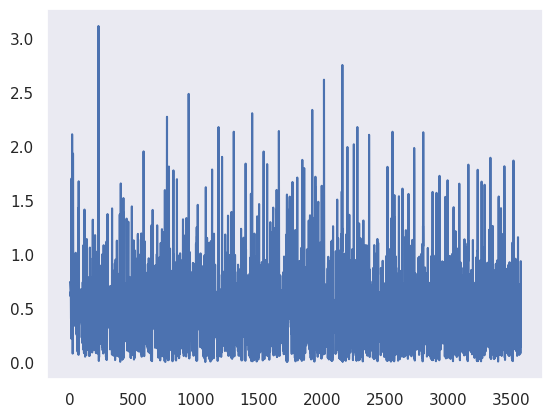

In [14]:
plt.plot(train_losses)

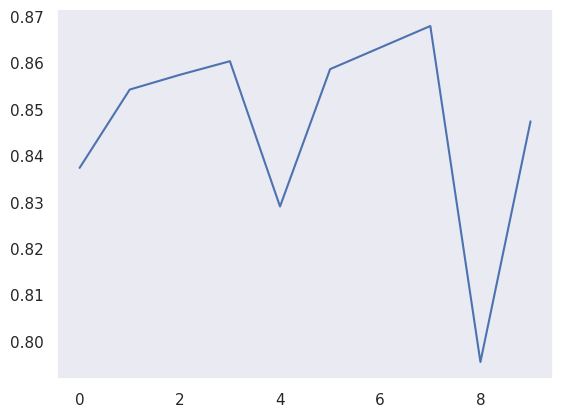

In [15]:
plt.plot(test_accuracy)

In [16]:
model_path = '../physio16k_fold4_m13sinc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [17]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [18]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3468/4064 (0.8533)
{'acc_detail': tensor([0.4483, 0.9800], device='cuda:0'),
 'acc_unweighted': tensor(0.7142, device='cuda:0'),
 'acc_weighted': tensor(0.8533, device='cuda:0'),
 'f1s': tensor(0.7517, device='cuda:0'),
 'f1s_detail': tensor([0.5929, 0.9106], device='cuda:0'),
 'precision_detail': tensor([0.8750, 0.8503], device='cuda:0'),
 'recall_detail': tensor([0.4483, 0.9800], device='cuda:0'),
 'rocauc': tensor([0.8967, 0.8967], device='cuda:0'),
 'uar': tensor(0.7142, device='cuda:0'),
 'wap': tensor(0.8562, device='cuda:0')}


tensor([[ 434,  534],
        [  62, 3034]], device='cuda:0')

In [19]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[ 0.0000],
        [ 0.1565],
        [ 0.0294],
        [-0.1687],
        [ 0.1131],
        [ 0.0495],
        [ 0.0610],
        [-0.0560],
        [-0.0395],
        [-0.0379],
        [-0.0401],
        [-0.0904],
        [ 0.1492],
        [ 0.1706],
        [-0.1282],
        [-0.0292],
        [-0.0406],
        [ 0.0849],
        [-0.0920],
        [ 0.0161],
        [ 0.1231],
        [-0.1167],
        [ 0.0980],
        [-0.0828],
        [ 0.1179],
        [ 0.0712],
        [-0.1262],
        [ 0.0213],
        [ 0.1202],
        [-0.0341],
        [ 0.0998],
        [-0.0532],
        [-0.0291],
        [ 0.0520],
        [-0.0411],
        [ 0.0065],
        [ 0.0774],
        [-0.0322],
        [ 0.0680],
        [-0.0235],
        [-0.1552],
        [-0.2017],
        [-0.0913],
        [ 0.1230],
        [ 0.0296],
        [-0.0480],
        [ 0.1273],
        [ 0.0115],
        [ 0.1842],
        [ 0.0236],
        [ 0

In [20]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000],
        [ 0.0166],
        [ 0.0200],
        [-0.0545],
        [ 0.0665],
        [ 0.0115],
        [ 0.0106],
        [-0.0663],
        [-0.1271],
        [-0.0308],
        [-0.0304],
        [-0.0240],
        [ 0.0155],
        [ 0.0588],
        [-0.0701],
        [-0.0071],
        [-0.0393],
        [ 0.0140],
        [-0.0458],
        [-0.1242],
        [-0.0721],
        [-0.1098],
        [ 0.0128],
        [-0.0233],
        [ 0.0452],
        [ 0.0089],
        [-0.0256],
        [-0.0110],
        [-0.0028],
        [ 0.0083],
        [-0.0011],
        [-0.0049],
        [-0.0619],
        [ 0.0084],
        [-0.0607],
        [ 0.0288],
        [ 0.0155],
        [-0.0402],
        [ 0.0127],
        [-0.0007],
        [-0.0721],
        [-0.0346],
        [-0.0199],
        [-0.0408],
        [ 0.0171],
        [-0.0367],
        [ 0.0108],
        [ 0.0566],
        [ 0.0069],
        [ 0.0191],
        [ 0.0644],
        [-0.0048],
        [-0.

[None, None]

(array([ 1.,  1.,  1.,  3.,  2.,  6.,  3.,  9.,  4.,  5.,  7.,  5.,  6.,
         9., 18.,  8.,  7.,  5.,  2.,  5.,  1.,  2.,  1.,  0.,  1.,  0.,
         3.,  3.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  1.,  0.,
         1.]),
 array([-0.20171779, -0.18025231, -0.15878683, -0.13732135, -0.11585587,
        -0.09439038, -0.0729249 , -0.05145942, -0.02999394, -0.00852846,
         0.01293702,  0.0344025 ,  0.05586799,  0.07733347,  0.09879895,
         0.12026443,  0.14172992,  0.1631954 ,  0.18466088,  0.20612636,
         0.22759184,  0.24905732,  0.2705228 ,  0.29198828,  0.31345376,
         0.33491924,  0.35638472,  0.3778502 ,  0.39931569,  0.42078117,
         0.44224668,  0.46371216,  0.48517764,  0.50664312,  0.5281086 ,
         0.54957408,  0.57103956,  0.59250504,  0.61397052,  0.635436  ,
         0.65690148]),
 <BarContainer object of 40 artists>)

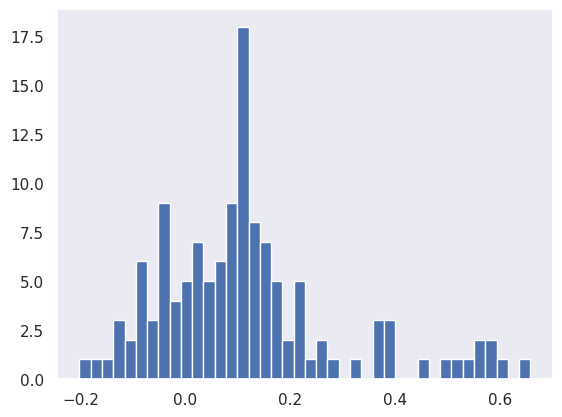

In [21]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,
         1.,  2., 12.,  6., 15., 15., 13., 17., 15., 10.,  3.,  7.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.]),
 array([-0.30007669, -0.28526238, -0.27044809, -0.25563377, -0.24081948,
        -0.22600518, -0.21119088, -0.19637658, -0.18156227, -0.16674797,
        -0.15193367, -0.13711935, -0.12230506, -0.10749076, -0.09267645,
        -0.07786214, -0.06304784, -0.04823354, -0.03341924, -0.01860493,
        -0.00379063,  0.01102367,  0.02583797,  0.04065228,  0.05546658,
         0.07028088,  0.08509519,  0.09990949,  0.11472379,  0.12953809,
         0.14435241,  0.15916671,  0.17398101,  0.18879531,  0.20360962,
         0.21842392,  0.23323822,  0.24805252,  0.26286682,  0.27768111,
         0.29249543]),
 <BarContainer object of 40 artists>)

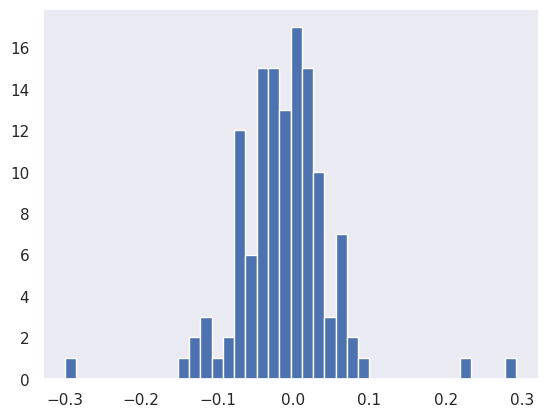

In [22]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  3.,  4.,  1.,  3.,  2.,  8.,  2.,  4.,  3.,
         4.,  5., 11.,  6.,  2.,  5.,  1.,  2.,  0.,  2.,  1.,  7.,  7.,
         8.,  9.,  6.,  5.,  3.,  1.,  3.,  0.,  2.,  2.,  3.,  0.,  0.,
         2.]),
 array([-0.21713081, -0.20683476, -0.19653872, -0.18624267, -0.17594662,
        -0.16565058, -0.15535451, -0.14505847, -0.13476242, -0.12446637,
        -0.11417033, -0.10387428, -0.09357823, -0.08328218, -0.07298613,
        -0.06269009, -0.05239404, -0.04209799, -0.03180194, -0.02150589,
        -0.01120985, -0.0009138 ,  0.00938225,  0.0196783 ,  0.02997435,
         0.0402704 ,  0.05056644,  0.06086249,  0.07115854,  0.08145459,
         0.09175064,  0.10204668,  0.11234273,  0.12263878,  0.13293482,
         0.14323089,  0.15352693,  0.16382298,  0.17411903,  0.18441507,
         0.19471112]),
 <BarContainer object of 40 artists>)

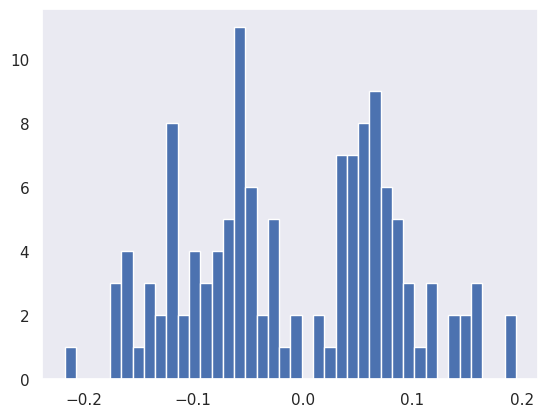

In [23]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  1.,  5.,  2.,  6., 12.,  8.,  8., 22., 19., 11.,
         3., 12.,  7.,  2.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,
         2.]),
 array([-0.24049541, -0.23042567, -0.22035593, -0.21028619, -0.20021644,
        -0.19014668, -0.18007694, -0.1700072 , -0.15993746, -0.14986771,
        -0.13979797, -0.12972823, -0.11965848, -0.10958873, -0.09951898,
        -0.08944924, -0.0793795 , -0.06930976, -0.05924001, -0.04917026,
        -0.03910052, -0.02903078, -0.01896103, -0.00889129,  0.00117846,
         0.0112482 ,  0.02131795,  0.03138769,  0.04145744,  0.05152718,
         0.06159693,  0.07166667,  0.08173642,  0.09180616,  0.1018759 ,
         0.11194565,  0.12201539,  0.13208514,  0.14215489,  0.15222463,
         0.16229437]),
 <BarContainer object of 40 artists>)

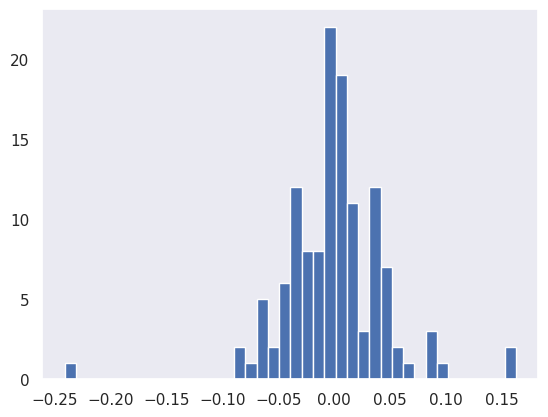

In [24]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

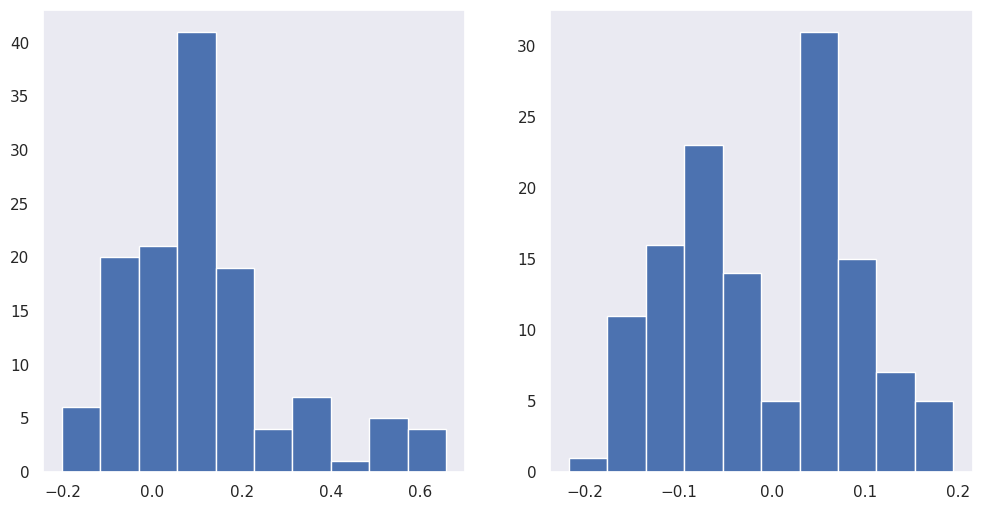

In [27]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

In [28]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0212, -0.2065,  0.1420,  ...,  0.1608,  0.2251,  0.1839],
        [ 0.1520, -0.1882,  0.2284,  ...,  0.2377, -0.0859,  0.0201],
        ...,
        [ 0.4683,  0.2689,  0.4730,  ...,  0.1648,  0.1561,  0.4594],
        [ 0.4875,  0.1887,  0.2106,  ...,  0.3427,  0.3264,  0.2364],
        [ 0.3576,  0.6140,  0.3535,  ...,  0.4236,  0.5007,  0.4877]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[ 0.4120,  0.2048,  0.3295,  ...,  0.2653,  0.1730,  0.2150],
        [ 0.0109,  0.1440, -0.1100,  ..., -0.1774,  0.0847, -0.1323],
        [ 0.0496,  0.1623,  0.2235,  ...,  0.1003, -0.1660, -0.0485],
        ...,
        [-0.4359, -0.0771,  0.2497,  ...,  0.1140, -0.1471,  0.2933],
        [ 0.4316,  0.1405,  0.0924,  ...,  0.1070,  0.1166, -0.1075],
        [-0.0548,  0.1058,  0.2538,  ...,  0.3565,  0.2399, -0.3339]],
       devi

downsample_factor: 8 => new_sample_rate: 2000


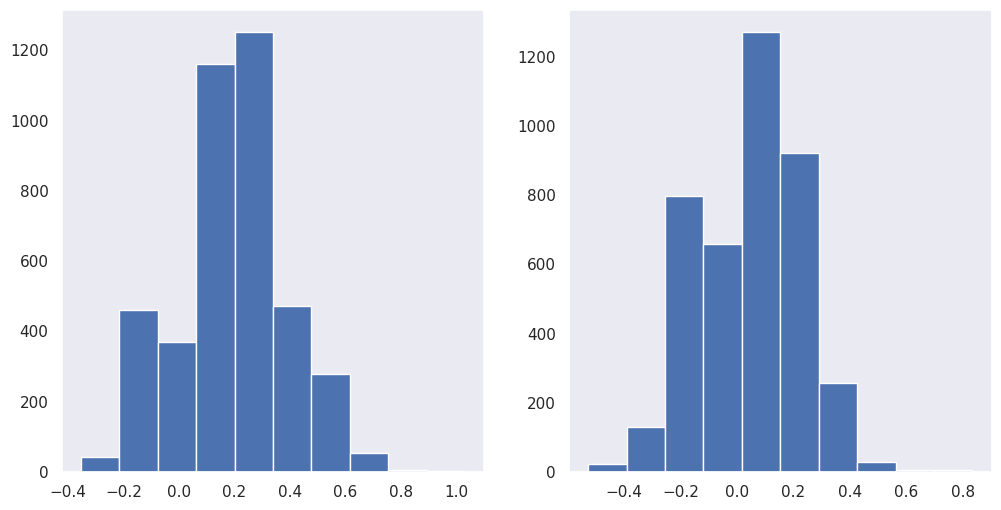

In [29]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

In [ ]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                      | 0.002061855670103093/50 [00:00<3:17:32, 237.06s/it]

Train Epoch: 11 [0/11481 (0%)]	Loss: 0.037031
Mem before-during-after: 20657664 4333061120 21483008


  0%|▏                                                                                                                      | 0.08453608247422686/50 [00:20<3:33:30, 256.65s/it]

Train Epoch: 11 [1280/11481 (11%)]	Loss: 0.096893
Mem before-during-after: 21483008 4332337152 21483008


  0%|▍                                                                                                                      | 0.16701030927835056/50 [00:41<3:32:18, 255.62s/it]

Train Epoch: 11 [2560/11481 (22%)]	Loss: 0.438635
Mem before-during-after: 21483008 4332337152 21483008


  0%|▌                                                                                                                      | 0.24948453608247398/50 [01:01<3:29:37, 252.82s/it]

Train Epoch: 11 [3840/11481 (34%)]	Loss: 0.030565
Mem before-during-after: 21483008 4332337152 21483008


  1%|▊                                                                                                                       | 0.3319587628865974/50 [01:22<3:29:32, 253.13s/it]

Train Epoch: 11 [5120/11481 (45%)]	Loss: 0.735297
Mem before-during-after: 21483008 4332337152 21483008


  1%|▉                                                                                                                      | 0.41443298969072084/50 [01:43<3:32:50, 257.55s/it]

Train Epoch: 11 [6400/11481 (56%)]	Loss: 0.250217
Mem before-during-after: 21483008 4332337152 21483008


  1%|█▏                                                                                                                     | 0.49690721649484426/50 [02:03<3:33:46, 259.10s/it]

Train Epoch: 11 [7680/11481 (67%)]	Loss: 0.094701
Mem before-during-after: 21483008 4332337152 21483008


  1%|█▍                                                                                                                      | 0.5793814432989677/50 [02:23<3:28:11, 252.76s/it]

Train Epoch: 11 [8960/11481 (78%)]	Loss: 0.093689
Mem before-during-after: 21483008 4332337152 21483008


  1%|█▌                                                                                                                      | 0.6618556701030911/50 [02:44<3:28:19, 253.35s/it]

Train Epoch: 11 [10240/11481 (89%)]	Loss: 0.205038
Mem before-during-after: 21483008 4332337152 21483008


  2%|██▍                                                                                                                     | 0.9999999999999971/50 [03:33<1:31:49, 112.45s/it]


Test Epoch: 11	Accuracy: 3560/4064 (87%)



  2%|██▍                                                                                                                     | 1.0020618556701002/50 [03:33<2:03:27, 151.18s/it]

Train Epoch: 12 [0/11481 (0%)]	Loss: 0.054293
Mem before-during-after: 21596672 4334000128 21483008


  2%|██▌                                                                                                                     | 1.0845360824742236/50 [03:54<3:37:28, 266.75s/it]

Train Epoch: 12 [1280/11481 (11%)]	Loss: 0.017028
Mem before-during-after: 21483008 4332337152 21483008


  2%|██▊                                                                                                                      | 1.167010309278347/50 [04:14<3:27:26, 254.88s/it]

Train Epoch: 12 [2560/11481 (22%)]	Loss: 0.285876
Mem before-during-after: 21483008 4332337152 21483008


  2%|██▉                                                                                                                     | 1.2494845360824705/50 [04:35<3:28:27, 256.57s/it]

Train Epoch: 12 [3840/11481 (34%)]	Loss: 0.004744
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▏                                                                                                                    | 1.3319587628865939/50 [04:55<3:26:13, 254.25s/it]

Train Epoch: 12 [5120/11481 (45%)]	Loss: 0.692617
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▍                                                                                                                    | 1.4144329896907173/50 [05:16<3:22:29, 250.07s/it]

Train Epoch: 12 [6400/11481 (56%)]	Loss: 0.201152
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▌                                                                                                                    | 1.4969072164948407/50 [05:36<3:23:37, 251.90s/it]

Train Epoch: 12 [7680/11481 (67%)]	Loss: 0.074582
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▊                                                                                                                    | 1.5793814432989641/50 [05:57<3:21:11, 249.30s/it]

Train Epoch: 12 [8960/11481 (78%)]	Loss: 0.087197
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▉                                                                                                                    | 1.6618556701030875/50 [06:16<3:18:56, 246.93s/it]

Train Epoch: 12 [10240/11481 (89%)]	Loss: 0.493886
Mem before-during-after: 21483008 4332337152 21483008


  4%|████▊                                                                                                                   | 1.9999999999999936/50 [07:05<1:29:12, 111.51s/it]


Test Epoch: 12	Accuracy: 3580/4064 (87%)



  4%|████▊                                                                                                                    | 2.002061855670097/50 [07:05<1:59:17, 149.11s/it]

Train Epoch: 13 [0/11481 (0%)]	Loss: 0.035424
Mem before-during-after: 21596672 4334000128 21483008


  4%|█████                                                                                                                   | 2.0845360824742203/50 [07:25<3:21:05, 251.80s/it]

Train Epoch: 13 [1280/11481 (11%)]	Loss: 0.030100
Mem before-during-after: 21483008 4332337152 21483008


  4%|█████▏                                                                                                                  | 2.1670103092783437/50 [07:46<3:22:43, 254.30s/it]

Train Epoch: 13 [2560/11481 (22%)]	Loss: 0.199875
Mem before-during-after: 21483008 4332337152 21483008


  4%|█████▍                                                                                                                   | 2.249484536082467/50 [08:06<3:21:28, 253.16s/it]

Train Epoch: 13 [3840/11481 (34%)]	Loss: 0.007856
Mem before-during-after: 21483008 4332337152 21483008


  5%|█████▌                                                                                                                  | 2.3319587628865905/50 [08:27<3:27:19, 260.96s/it]

Train Epoch: 13 [5120/11481 (45%)]	Loss: 0.812270
Mem before-during-after: 21483008 4332337152 21483008


  5%|█████▊                                                                                                                   | 2.414432989690714/50 [08:47<3:22:11, 254.94s/it]

Train Epoch: 13 [6400/11481 (56%)]	Loss: 0.172510
Mem before-during-after: 21483008 4332337152 21483008


  5%|█████▉                                                                                                                  | 2.4969072164948374/50 [09:08<3:19:14, 251.66s/it]

Train Epoch: 13 [7680/11481 (67%)]	Loss: 0.098996
Mem before-during-after: 21483008 4332337152 21483008


  5%|██████▏                                                                                                                  | 2.579381443298961/50 [09:28<3:15:41, 247.60s/it]

Train Epoch: 13 [8960/11481 (78%)]	Loss: 0.089928
Mem before-during-after: 21483008 4332337152 21483008


  5%|██████▍                                                                                                                  | 2.661855670103084/50 [09:48<3:20:15, 253.82s/it]

Train Epoch: 13 [10240/11481 (89%)]	Loss: 0.448549
Mem before-during-after: 21483008 4332337152 21483008


  6%|███████▏                                                                                                                | 2.9999999999999902/50 [10:37<1:27:02, 111.11s/it]


Test Epoch: 13	Accuracy: 3580/4064 (87%)



  6%|███████▏                                                                                                                | 3.0020618556700933/50 [10:37<1:56:58, 149.34s/it]

Train Epoch: 14 [0/11481 (0%)]	Loss: 0.040248
Mem before-during-after: 21596672 4334000128 21483008


  6%|███████▍                                                                                                                | 3.0845360824742167/50 [10:58<3:17:26, 252.51s/it]

Train Epoch: 14 [1280/11481 (11%)]	Loss: 0.089087
Mem before-during-after: 21483008 4332337152 21483008


  6%|███████▋                                                                                                                  | 3.16701030927834/50 [11:18<3:14:25, 249.09s/it]

Train Epoch: 14 [2560/11481 (22%)]	Loss: 0.311855
Mem before-during-after: 21483008 4332337152 21483008


  6%|███████▊                                                                                                                | 3.2494845360824636/50 [11:38<3:15:24, 250.79s/it]

Train Epoch: 14 [3840/11481 (34%)]	Loss: 0.004908
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████                                                                                                                 | 3.331958762886587/50 [11:58<3:13:31, 248.80s/it]

Train Epoch: 14 [5120/11481 (45%)]	Loss: 0.849340
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▏                                                                                                               | 3.4144329896907104/50 [12:19<3:13:41, 249.47s/it]

Train Epoch: 14 [6400/11481 (56%)]	Loss: 0.178647
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▍                                                                                                                | 3.496907216494834/50 [12:39<3:15:02, 251.65s/it]

Train Epoch: 14 [7680/11481 (67%)]	Loss: 0.084415
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▌                                                                                                               | 3.5793814432989572/50 [12:59<3:11:38, 247.70s/it]

Train Epoch: 14 [8960/11481 (78%)]	Loss: 0.094435
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▊                                                                                                               | 3.6618556701030807/50 [13:19<3:13:07, 250.07s/it]

Train Epoch: 14 [10240/11481 (89%)]	Loss: 0.408223
Mem before-during-after: 21483008 4332337152 21483008


  8%|█████████▌                                                                                                              | 3.9999999999999867/50 [14:08<1:27:09, 113.68s/it]


Test Epoch: 14	Accuracy: 3574/4064 (87%)



  8%|█████████▊                                                                                                                | 4.00206185567009/50 [14:08<1:55:36, 150.79s/it]

Train Epoch: 15 [0/11481 (0%)]	Loss: 0.073131
Mem before-during-after: 21596672 4334000128 21483008


  8%|█████████▉                                                                                                               | 4.084536082474213/50 [14:29<3:16:04, 256.23s/it]

Train Epoch: 15 [1280/11481 (11%)]	Loss: 0.015276
Mem before-during-after: 21483008 4332337152 21483008


  8%|██████████                                                                                                               | 4.167010309278337/50 [14:49<3:14:54, 255.16s/it]

Train Epoch: 15 [2560/11481 (22%)]	Loss: 0.375426
Mem before-during-after: 21483008 4332337152 21483008


  8%|██████████▎                                                                                                               | 4.24948453608246/50 [15:10<3:13:27, 253.71s/it]

Train Epoch: 15 [3840/11481 (34%)]	Loss: 0.004467
Mem before-during-after: 21483008 4332337152 21483008


  9%|██████████▍                                                                                                              | 4.331958762886583/50 [15:30<3:11:48, 252.00s/it]

Train Epoch: 15 [5120/11481 (45%)]	Loss: 0.837265
Mem before-during-after: 21483008 4332337152 21483008


  9%|██████████▋                                                                                                              | 4.414432989690707/50 [15:51<3:12:26, 253.29s/it]

Train Epoch: 15 [6400/11481 (56%)]	Loss: 0.185020
Mem before-during-after: 21483008 4332337152 21483008


  9%|██████████▉                                                                                                               | 4.49690721649483/50 [16:11<3:13:39, 255.35s/it]

Train Epoch: 15 [7680/11481 (67%)]	Loss: 0.098444
Mem before-during-after: 21483008 4332337152 21483008


  9%|███████████                                                                                                              | 4.579381443298954/50 [16:32<3:11:50, 253.42s/it]

Train Epoch: 15 [8960/11481 (78%)]	Loss: 0.088382
Mem before-during-after: 21483008 4332337152 21483008


  9%|███████████▎                                                                                                             | 4.661855670103077/50 [16:53<3:13:50, 256.54s/it]

Train Epoch: 15 [10240/11481 (89%)]	Loss: 0.756241
Mem before-during-after: 21483008 4332337152 21483008


 10%|████████████                                                                                                             | 4.999999999999983/50 [17:41<1:21:55, 109.23s/it]


Test Epoch: 15	Accuracy: 3563/4064 (87%)



 10%|████████████                                                                                                             | 5.002061855670086/50 [17:41<1:51:53, 149.20s/it]

Train Epoch: 16 [0/11481 (0%)]	Loss: 0.038432
Mem before-during-after: 21596672 4334000128 21483008


 10%|████████████▍                                                                                                             | 5.08453608247421/50 [18:01<3:06:01, 248.49s/it]

Train Epoch: 16 [1280/11481 (11%)]	Loss: 0.035013
Mem before-during-after: 21483008 4332337152 21483008


 10%|████████████▌                                                                                                            | 5.167010309278333/50 [18:22<3:05:27, 248.19s/it]

Train Epoch: 16 [2560/11481 (22%)]	Loss: 0.167058
Mem before-during-after: 21483008 4332337152 21483008


 10%|████████████▌                                                                                                           | 5.2494845360824565/50 [18:42<3:07:07, 250.88s/it]

Train Epoch: 16 [3840/11481 (34%)]	Loss: 0.005457
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████                                                                                                             | 5.33195876288658/50 [19:02<3:07:11, 251.44s/it]

Train Epoch: 16 [5120/11481 (45%)]	Loss: 0.805120
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████                                                                                                            | 5.414432989690703/50 [19:22<3:07:09, 251.87s/it]

Train Epoch: 16 [6400/11481 (56%)]	Loss: 0.187904
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████▎                                                                                                           | 5.496907216494827/50 [19:43<3:06:54, 252.00s/it]

Train Epoch: 16 [7680/11481 (67%)]	Loss: 0.122649
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████▌                                                                                                            | 5.57938144329895/50 [20:03<3:04:09, 248.75s/it]

Train Epoch: 16 [8960/11481 (78%)]	Loss: 0.083121
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████▋                                                                                                           | 5.661855670103074/50 [20:23<3:05:44, 251.36s/it]

Train Epoch: 16 [10240/11481 (89%)]	Loss: 0.644543
Mem before-during-after: 21483008 4332337152 21483008


 12%|██████████████▋                                                                                                           | 5.99999999999998/50 [21:11<1:22:52, 113.02s/it]


Test Epoch: 16	Accuracy: 3550/4064 (87%)



 12%|██████████████▌                                                                                                          | 6.002061855670083/50 [21:12<1:49:33, 149.39s/it]

Train Epoch: 17 [0/11481 (0%)]	Loss: 0.052308
Mem before-during-after: 21596672 4334000128 21483008


 12%|██████████████▋                                                                                                          | 6.084536082474206/50 [21:32<3:04:32, 252.12s/it]

Train Epoch: 17 [1280/11481 (11%)]	Loss: 0.150426
Mem before-during-after: 21483008 4332337152 21483008


 12%|██████████████▊                                                                                                         | 6.1670103092783295/50 [21:53<3:05:15, 253.58s/it]

Train Epoch: 17 [2560/11481 (22%)]	Loss: 0.196108
Mem before-during-after: 21483008 4332337152 21483008


 12%|███████████████                                                                                                          | 6.249484536082453/50 [22:14<3:14:00, 266.08s/it]

Train Epoch: 17 [3840/11481 (34%)]	Loss: 0.005206
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▎                                                                                                         | 6.331958762886576/50 [22:34<3:04:29, 253.48s/it]

Train Epoch: 17 [5120/11481 (45%)]	Loss: 0.814012
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▊                                                                                                           | 6.4144329896907/50 [22:54<3:02:27, 251.16s/it]

Train Epoch: 17 [6400/11481 (56%)]	Loss: 0.238394
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▋                                                                                                         | 6.496907216494823/50 [23:15<3:04:18, 254.20s/it]

Train Epoch: 17 [7680/11481 (67%)]	Loss: 0.089573
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▉                                                                                                         | 6.579381443298947/50 [23:35<3:01:20, 250.59s/it]

Train Epoch: 17 [8960/11481 (78%)]	Loss: 0.103607
Mem before-during-after: 21483008 4332337152 21483008


 13%|████████████████▎                                                                                                         | 6.66185567010307/50 [23:55<3:00:29, 249.89s/it]

Train Epoch: 17 [10240/11481 (89%)]	Loss: 0.677990
Mem before-during-after: 21483008 4332337152 21483008


 14%|████████████████▉                                                                                                        | 6.999999999999976/50 [24:43<1:18:43, 109.86s/it]


Test Epoch: 17	Accuracy: 3538/4064 (86%)



 14%|████████████████▉                                                                                                        | 7.002061855670079/50 [24:43<1:45:46, 147.60s/it]

Train Epoch: 18 [0/11481 (0%)]	Loss: 0.102512
Mem before-during-after: 21596672 4334000128 21483008


 14%|█████████████████                                                                                                       | 7.0845360824742025/50 [25:04<2:59:33, 251.03s/it]

Train Epoch: 18 [1280/11481 (11%)]	Loss: 0.070359
Mem before-during-after: 21483008 4332337152 21483008


 14%|█████████████████▎                                                                                                       | 7.167010309278326/50 [25:24<2:58:40, 250.29s/it]

Train Epoch: 18 [2560/11481 (22%)]	Loss: 0.199785
Mem before-during-after: 21483008 4332337152 21483008


 14%|█████████████████▌                                                                                                       | 7.249484536082449/50 [25:44<2:57:15, 248.79s/it]

Train Epoch: 18 [3840/11481 (34%)]	Loss: 0.007419
Mem before-during-after: 21483008 4332337152 21483008


 15%|█████████████████▋                                                                                                       | 7.331958762886573/50 [26:05<2:57:44, 249.94s/it]

Train Epoch: 18 [5120/11481 (45%)]	Loss: 0.863784
Mem before-during-after: 21483008 4332337152 21483008


 15%|█████████████████▉                                                                                                       | 7.414432989690696/50 [26:25<3:09:06, 266.45s/it]

Train Epoch: 18 [6400/11481 (56%)]	Loss: 0.163511
Mem before-during-after: 21483008 4332337152 21483008


 15%|██████████████████▎                                                                                                       | 7.49690721649482/50 [26:45<2:56:45, 249.51s/it]

Train Epoch: 18 [7680/11481 (67%)]	Loss: 0.106601
Mem before-during-after: 21483008 4332337152 21483008


 15%|██████████████████▎                                                                                                      | 7.579381443298943/50 [27:05<2:56:12, 249.24s/it]

Train Epoch: 18 [8960/11481 (78%)]	Loss: 0.081721
Mem before-during-after: 21483008 4332337152 21483008


 15%|██████████████████▍                                                                                                     | 7.6618556701030665/50 [27:26<2:53:32, 245.93s/it]

Train Epoch: 18 [10240/11481 (89%)]	Loss: 0.282498
Mem before-during-after: 21483008 4332337152 21483008


 16%|███████████████████▏                                                                                                    | 7.9999999999999725/50 [28:14<1:23:57, 119.94s/it]


Test Epoch: 18	Accuracy: 3561/4064 (87%)



 16%|███████████████████▎                                                                                                     | 8.002061855670076/50 [28:14<1:49:51, 156.95s/it]

Train Epoch: 19 [0/11481 (0%)]	Loss: 0.018868
Mem before-during-after: 21596672 4334000128 21483008


 16%|███████████████████▉                                                                                                       | 8.0845360824742/50 [28:35<2:55:35, 251.34s/it]

Train Epoch: 19 [1280/11481 (11%)]	Loss: 0.063385
Mem before-during-after: 21483008 4332337152 21483008


 16%|███████████████████▊                                                                                                     | 8.167010309278323/50 [28:55<2:57:39, 254.81s/it]

Train Epoch: 19 [2560/11481 (22%)]	Loss: 0.157796
Mem before-during-after: 21483008 4332337152 21483008


 16%|███████████████████▉                                                                                                     | 8.249484536082447/50 [29:16<2:58:57, 257.17s/it]

Train Epoch: 19 [3840/11481 (34%)]	Loss: 0.008408
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▎                                                                                                     | 8.33195876288657/50 [29:37<2:56:29, 254.13s/it]

Train Epoch: 19 [5120/11481 (45%)]	Loss: 0.916085
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▎                                                                                                    | 8.414432989690694/50 [29:58<2:55:55, 253.81s/it]

Train Epoch: 19 [6400/11481 (56%)]	Loss: 0.219158
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▌                                                                                                    | 8.496907216494817/50 [30:18<2:56:49, 255.63s/it]

Train Epoch: 19 [7680/11481 (67%)]	Loss: 0.092289
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▉                                                                                                     | 8.57938144329894/50 [30:39<2:57:15, 256.76s/it]

Train Epoch: 19 [8960/11481 (78%)]	Loss: 0.075188
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▉                                                                                                    | 8.661855670103064/50 [31:00<2:57:22, 257.46s/it]

Train Epoch: 19 [10240/11481 (89%)]	Loss: 1.024253
Mem before-during-after: 21483008 4332337152 21483008


 18%|█████████████████████▉                                                                                                    | 8.99999999999997/50 [31:49<1:17:26, 113.33s/it]


Test Epoch: 19	Accuracy: 3557/4064 (87%)



 18%|█████████████████████▊                                                                                                   | 9.002061855670073/50 [31:49<1:46:21, 155.64s/it]

Train Epoch: 20 [0/11481 (0%)]	Loss: 0.041981
Mem before-during-after: 21596672 4334000128 21483008


 18%|█████████████████████▉                                                                                                   | 9.084536082474196/50 [32:10<2:51:31, 251.54s/it]

Train Epoch: 20 [1280/11481 (11%)]	Loss: 0.141832
Mem before-during-after: 21483008 4332337152 21483008


 18%|██████████████████████▎                                                                                                   | 9.16701030927832/50 [32:30<2:49:53, 249.63s/it]

Train Epoch: 20 [2560/11481 (22%)]	Loss: 0.192657
Mem before-during-after: 21483008 4332337152 21483008


 18%|██████████████████████▍                                                                                                  | 9.249484536082443/50 [32:51<2:51:50, 253.02s/it]

Train Epoch: 20 [3840/11481 (34%)]	Loss: 0.010378
Mem before-during-after: 21483008 4332337152 21483008


 19%|██████████████████████▌                                                                                                  | 9.331958762886567/50 [33:11<2:50:55, 252.18s/it]

Train Epoch: 20 [5120/11481 (45%)]	Loss: 0.897745
Mem before-during-after: 21483008 4332337152 21483008


 19%|██████████████████████▉                                                                                                   | 9.41443298969069/50 [33:31<2:48:22, 248.93s/it]

Train Epoch: 20 [6400/11481 (56%)]	Loss: 0.236596
Mem before-during-after: 21483008 4332337152 21483008


 19%|███████████████████████                                                                                                   | 9.43505154639172/50 [33:36<2:47:52, 248.32s/it]

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model_path = '../physio16k_fold4_m13sinc_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [ ]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

In [ ]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

In [ ]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

In [ ]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

In [ ]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

In [ ]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

In [ ]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

In [ ]:
named_params12 = [p for p in layer.named_parameters()]
lowbands12 = named_params12[0][1].detach().cpu().numpy()
plt.hist(lowbands12.flatten(), bins=40)

In [ ]:
lowbands12 = named_params12[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands12.flatten(), bins=40)

In [ ]:
bandwidths12 = named_params12[1][1].detach().cpu().numpy()
plt.hist(bandwidths12.flatten(), bins=40)

In [ ]:
bandwidths12 = named_params12[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths12.flatten(), bins=40)

In [ ]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

In [ ]:
named_params22 = [p for p in layer22.named_parameters()]
lowbands22 = named_params22[0][1].detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

In [ ]:
lowbands22 = named_params22[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

In [ ]:
bandwidth22 = named_params22[1][1].detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

In [ ]:
bandwidths22 = named_params22[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

In [ ]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

In [77]:
# del model
# gc.collect()

340729